In [0]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv

import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [0]:
!wget  http://opihi.cs.uvic.ca/sound/genres.tar.gz

--2020-05-11 13:30:42--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G   938KB/s    in 20m 56s 

2020-05-11 13:51:38 (953 KB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/Music Classification/genres.tar" "/content"

In [3]:
!gunzip genres.tar.gz
!tar -xvf genres.tar

gzip: genres.tar.gz: No such file or directory
genres/
genres/bextract_single.mf
genres/bl.mf
genres/blues/
genres/cl.mf
genres/classical/
genres/co.mf
genres/country/
genres/di.mf
genres/disco/
genres/hi.mf
genres/hiphop/
genres/input.mf
genres/ja.mf
genres/jazz/
genres/me.mf
genres/metal/
genres/po.mf
genres/pop/
genres/re.mf
genres/reggae/
genres/ro.mf
genres/rock/
genres/rock/rock.00000.wav
genres/rock/rock.00001.wav
genres/rock/rock.00002.wav
genres/rock/rock.00003.wav
genres/rock/rock.00004.wav
genres/rock/rock.00005.wav
genres/rock/rock.00006.wav
genres/rock/rock.00007.wav
genres/rock/rock.00008.wav
genres/rock/rock.00009.wav
genres/rock/rock.00010.wav
genres/rock/rock.00011.wav
genres/rock/rock.00012.wav
genres/rock/rock.00013.wav
genres/rock/rock.00014.wav
genres/rock/rock.00015.wav
genres/rock/rock.00016.wav
genres/rock/rock.00017.wav
genres/rock/rock.00018.wav
genres/rock/rock.00019.wav
genres/rock/rock.00020.wav
genres/rock/rock.00021.wav
genres/rock/rock.00022.wav
genres/r

In [0]:
def getGenres():
  return ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Classification based on features from the songs

# Features extraction

---
*   Mel-frequency cepstral coefficients (MFCC)(20 in number)
*   Spectral Centroid
*   Zero Crossing Rate
*   Chroma Frequencies
*   Spectral Roll-off







In [0]:

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = getGenres()
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [0]:
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)


In [0]:
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.280714,0.102002,1210.197917,1497.822809,2522.101416,0.052483,-227.264777,137.762370,-14.500459,63.556877,5.626699,11.961589,1.906221,-1.880768,-7.609113,-2.470595,-2.884145,-9.432815,-10.916915,3.569436,4.139583,0.092946,-2.972928,-1.376940,7.550499,-3.032518,blues
1,0.302346,0.103468,1831.942368,1729.483241,3480.937285,0.094040,-177.869048,118.196916,-17.550673,30.758635,-21.742746,11.903802,-20.734249,3.180597,-8.583484,-0.936488,-11.776273,-2.420615,-9.339365,-9.939325,-3.909892,-5.570625,-1.839023,-2.778421,-3.046866,-8.115809,blues
2,0.393756,0.196723,1977.172377,1927.803692,3942.834492,0.106627,-55.579243,114.935848,-37.052831,64.896513,-7.139353,15.238385,-16.222615,18.630809,-9.745892,21.460042,-5.641416,12.782317,-16.528681,3.793788,-7.890870,8.477609,-4.065210,3.207441,-5.178250,-1.279524,blues
3,0.341865,0.259714,2094.919420,2158.335963,4482.447895,0.100570,-30.094571,103.732289,-19.754240,56.404770,-12.710990,20.188002,-17.340381,16.292435,-18.439600,8.924175,-11.648016,11.213472,-8.842511,9.090302,-3.579252,4.372714,-2.830807,4.725089,0.485058,1.475955,blues
4,0.288721,0.095768,1391.367710,1494.892439,2811.108002,0.072359,-228.227985,130.353549,-23.297618,70.173662,1.137060,7.609717,0.915008,1.989320,-6.161290,-9.390745,-2.566142,-4.523861,-0.266734,0.181102,-1.513057,1.460950,-6.976431,-8.318999,4.241007,0.979682,blues


In [0]:
data.shape

(1000, 27)

In [0]:
genre_list = data.iloc[:, -1]
# Extracting labels
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [0]:
X.shape[1]

26

In [0]:
from keras import models
from keras import layers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=60, validation_split=0.25, batch_size=16)

Train on 600 samples, validate on 200 samples
Epoch 1/60
600/600 [==============================] - 2s 3ms/step - loss: 2.6925 - accuracy: 0.1400 - val_loss: 2.0594 - val_accuracy: 0.3500
Epoch 2/60
600/600 [==============================] - 0s 305us/step - loss: 2.1978 - accuracy: 0.2650 - val_loss: 1.9116 - val_accuracy: 0.2950
Epoch 3/60
600/600 [==============================] - 0s 286us/step - loss: 2.0307 - accuracy: 0.3200 - val_loss: 1.8355 - val_accuracy: 0.3100
Epoch 4/60
600/600 [==============================] - 0s 280us/step - loss: 2.0238 - accuracy: 0.3033 - val_loss: 1.7425 - val_accuracy: 0.3600
Epoch 5/60
600/600 [==============================] - 0s 289us/step - loss: 1.9225 - accuracy: 0.3550 - val_loss: 1.6739 - val_accuracy: 0.3900
Epoch 6/60
600/600 [==============================] - 0s 277us/step - loss: 1.8265 - accuracy: 0.3667 - val_loss: 1.6068 - val_accuracy: 0.4150
Epoch 7/60
600/600 [==============================] - 0s 272us/step - loss: 1.7228 - accurac

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9816660404205322
Test accuracy: 0.6499999761581421


In [0]:
predictions = model.predict(X_test)
print('First prediction:', max(predictions[0]))

First prediction: 0.97664136


# Classification using MelSpectogram and CNN

In [7]:
import matplotlib.pyplot as plt
import librosa.display

# mel-spectrogram parameters
SR = 12000
N_FFT = 512
N_MELS = 96
HOP_LEN = 256

cmap = plt.get_cmap('inferno')

genres = getGenres()
for g in genres:
    pathlib.Path(f'mel_spectogram/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname)
        S = librosa.feature.melspectrogram(y, sr=SR, n_fft=N_FFT, 
                                   hop_length=HOP_LEN, 
                                   n_mels=N_MELS)
        S_DB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_DB, sr=SR, hop_length=HOP_LEN, 
                         x_axis='time', y_axis='mel');
        plt.colorbar(format='%+2.0f dB');
        plt.savefig(f'mel_spectogram/{g}/{filename[:-3].replace(".", "")}.jpg')
        plt.clf()

<Figure size 432x288 with 0 Axes>

In [0]:
# cp -r mel_spectogram/ mel_spectogram_copy/

# Expected folder structure

*   modeldata
  *  train
     *  blues  
     *  classical  
     *  ....  
  *  test
     *  blues  
     *  classical  
     *  ....  
  *  validation
     *  blues  
     *  classical  
     *  ....  











In [8]:
import numpy as np
import os, shutil
import errno

original_dataset_dir = 'mel_spectogram'

base_dir = 'modeldata'
try:
  os.mkdir(base_dir)
except:
  pass

folders = [
  {'name': 'train', 'size': 70},
  {'name': 'test', 'size': 10},
  {'name': 'validation', 'size': 20}
]
for f in folders:
  directory = os.path.join(base_dir, f["name"])
  try:
    os.mkdir(directory)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise
    pass
  genres = getGenres()
  for g in genres:
    genre_directory = os.path.join(directory, g)
    try:
      os.mkdir(genre_directory)
    except:
      pass
    fnames = [f'{g}00{str(s).zfill(3)}.jpg' for s in range(f["size"])]
    for fname in fnames:
      src = os.path.join(original_dataset_dir+f'/{g}', fname)
      dst = os.path.join(genre_directory, fname)
      print(src)
      print(dst)
      shutil.copyfile(src, dst)

mel_spectogram/blues/blues00000.jpg
modeldata/train/blues/blues00000.jpg
mel_spectogram/blues/blues00001.jpg
modeldata/train/blues/blues00001.jpg
mel_spectogram/blues/blues00002.jpg
modeldata/train/blues/blues00002.jpg
mel_spectogram/blues/blues00003.jpg
modeldata/train/blues/blues00003.jpg
mel_spectogram/blues/blues00004.jpg
modeldata/train/blues/blues00004.jpg
mel_spectogram/blues/blues00005.jpg
modeldata/train/blues/blues00005.jpg
mel_spectogram/blues/blues00006.jpg
modeldata/train/blues/blues00006.jpg
mel_spectogram/blues/blues00007.jpg
modeldata/train/blues/blues00007.jpg
mel_spectogram/blues/blues00008.jpg
modeldata/train/blues/blues00008.jpg
mel_spectogram/blues/blues00009.jpg
modeldata/train/blues/blues00009.jpg
mel_spectogram/blues/blues00010.jpg
modeldata/train/blues/blues00010.jpg
mel_spectogram/blues/blues00011.jpg
modeldata/train/blues/blues00011.jpg
mel_spectogram/blues/blues00012.jpg
modeldata/train/blues/blues00012.jpg
mel_spectogram/blues/blues00013.jpg
modeldata/train

In [0]:
# rm -rf modeldata
#!rm -d modeldata
#!rm -r modeldata

In [1]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        directory='modeldata/train',  # this is the target directory
        target_size=(96, 1366),  
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        directory='modeldata/validation',  # this is the target directory
        target_size=(96, 1366),  
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        directory='modeldata/test',  # this is the target directory
        target_size=(96, 1366),  
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

Using TensorFlow backend.


Found 700 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


**CNN Classification**

In [7]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

model = models.Sequential()
model.add(layers.BatchNormalization(name='bn_0_freq',input_shape=(96, 1366, 3)))
   # Conv block 1
model.add(layers.Conv2D(32,kernel_size=(3, 3), border_mode='same', name='conv1',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.BatchNormalization(name='bn1'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(2, 4), name='pool1'))
   # Conv block 2
model.add(layers.Conv2D(128,kernel_size=(3, 3), border_mode='same', name='conv2',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.BatchNormalization(name='bn2'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(2, 4), name='pool2'))
   # Conv block 3
model.add(layers.Conv2D(128,kernel_size=(3, 3), border_mode='same', name='conv3',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.BatchNormalization(name='bn3'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(2, 4), name='pool3'))
   # Conv block 4
model.add(layers.Conv2D(192,kernel_size=(3, 3), border_mode='same', name='conv4',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.BatchNormalization(name='bn4'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(3, 5), name='pool4'))
  # Conv block 5
model.add(layers.Conv2D(256,kernel_size=(3, 3), border_mode='same', name='conv5',kernel_regularizer= regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.BatchNormalization(name='bn5'))
model.add(layers.ELU())
model.add(layers.MaxPooling2D(pool_size=(4, 4), name='pool5'))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='sigmoid', name='output'))
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(3, 3), name="conv1", kernel_regularizer=<keras.reg..., padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, kernel_size=(3, 3), name="conv2", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, kernel_size=(3, 3), name="conv3", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, kernel_size=(3, 3), name="conv4", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your

In [4]:
model.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f438c2844e0>>

In [0]:
#my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=4,monitor='val_loss',mode='min')]

In [8]:
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history= model.fit_generator(
                train_generator,
                steps_per_epoch= train_generator.labels.size//batch_size,
                epochs=20,
                validation_data=validation_generator,
                validation_steps= validation_generator.labels.size//batch_size,
                use_multiprocessing=True,
                shuffle= True,
                #callbacks=my_callbacks,
                workers=10)

Epoch 1/20
43/43 [==============================] - 13s 294ms/step - loss: 2.3398 - acc: 0.1506 - val_loss: 7.7070 - val_acc: 0.1510
Epoch 2/20
43/43 [==============================] - 10s 241ms/step - loss: 2.0414 - acc: 0.3319 - val_loss: 3.8824 - val_acc: 0.2120
Epoch 3/20
43/43 [==============================] - 11s 252ms/step - loss: 1.7678 - acc: 0.4430 - val_loss: 2.6278 - val_acc: 0.2826
Epoch 4/20
43/43 [==============================] - 11s 248ms/step - loss: 1.5433 - acc: 0.5263 - val_loss: 1.9877 - val_acc: 0.4076
Epoch 5/20
43/43 [==============================] - 11s 249ms/step - loss: 1.3410 - acc: 0.6111 - val_loss: 2.5987 - val_acc: 0.4185
Epoch 6/20
43/43 [==============================] - 11s 246ms/step - loss: 1.1851 - acc: 0.6579 - val_loss: 1.8241 - val_acc: 0.4891
Epoch 7/20
43/43 [==============================] - 11s 252ms/step - loss: 1.0949 - acc: 0.7032 - val_loss: 2.2087 - val_acc: 0.4946
Epoch 8/20
43/43 [==============================] - 11s 253ms/step - 

In [18]:
model.predict_generator(test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3169601261615753
Test accuracy: 0.8899999856948853


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

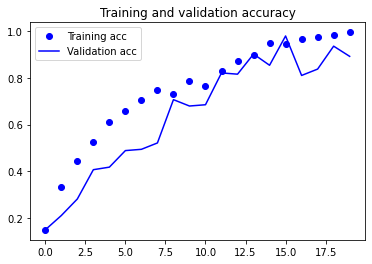

In [13]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

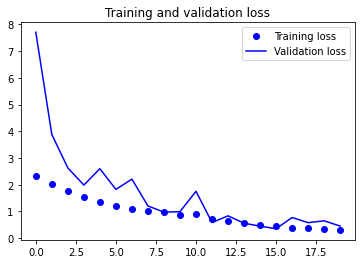

In [14]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn  as  sns

Y_pred = model.predict_generator(test_generator, 100 // batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[2 1 1 1 0 1 2 1 0 1]
 [1 0 1 2 0 1 1 2 0 2]
 [1 1 0 2 0 2 0 2 1 1]
 [0 1 2 1 0 1 1 0 3 1]
 [2 2 0 0 0 1 1 1 1 2]
 [4 1 1 1 0 1 1 0 0 1]
 [2 1 0 1 0 2 2 2 0 0]
 [3 2 2 0 0 0 0 0 2 1]
 [2 0 3 1 0 0 1 1 1 1]
 [2 1 0 1 0 1 1 1 2 1]]
Classification Report
              precision    recall  f1-score   support

       blues       0.11      0.20      0.14        10
   classical       0.00      0.00      0.00        10
     country       0.00      0.00      0.00        10
       disco       0.10      0.10      0.10        10
      hiphop       0.00      0.00      0.00        10
        jazz       0.10      0.10      0.10        10
       metal       0.20      0.20      0.20        10
         pop       0.00      0.00      0.00        10
      reggae       0.10      0.10      0.10        10
        rock       0.09      0.10      0.10        10

    accuracy                           0.08       100
   macro avg       0.07      0.08      0.07       100
weighted avg       0.07   

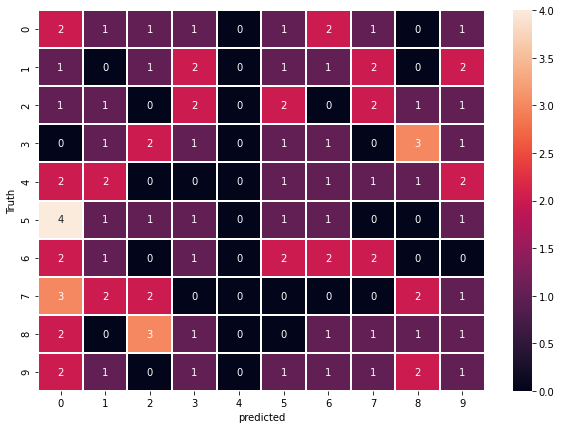

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(test_generator.classes, y_pred),annot=True,linewidths=1, fmt = 'd')
plt.xlabel('predicted')
plt.ylabel('Truth')
plt.show()